In [1]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["font.size"] = 18

np.random.seed(1942)

# 1 **Set up**

In [38]:
x, y = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

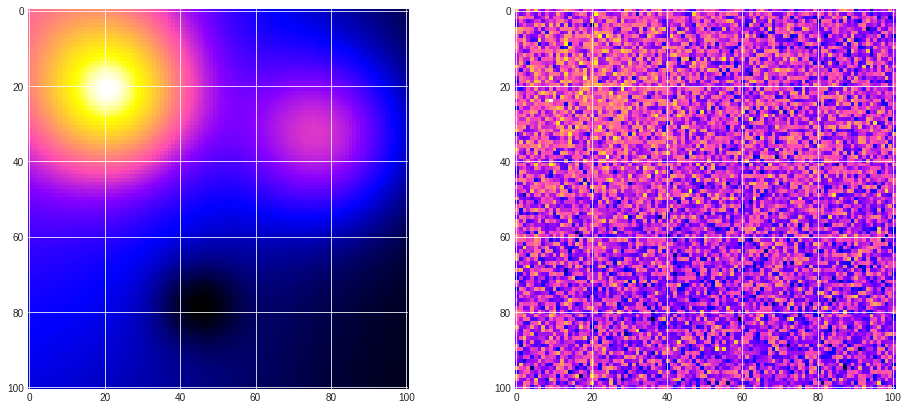

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
franke_noiseless = FrankeCentered(reg.x_mesh, reg.y_mesh)
ax1.imshow(franke_noiseless);
ax2.imshow(reg.f);

# 2. **OLS**

fitting 

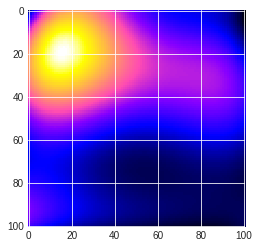

In [40]:
beta_ols = reg.solveCoefficients(poly_order=5, solver="OLS")
data_pred_ols = reg.apply_model(beta_ols, reg.x_mesh, reg.y_mesh)

plt.imshow(data_pred_ols);

**Error**

In [41]:
mse = MSE(reg.f, data_pred_ols)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(reg.f, data_pred_ols)
print("metrics vs noisy franke (data trained on): ", mse, rmse, rrmse, r2)

mse = MSE(franke_noiseless, data_pred_ols)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(franke_noiseless, data_pred_ols)
print("metrics vs noiseless franke: ", mse, rmse, rrmse, r2)


metrics vs noisy franke (data trained on):  1.0073002064061083 1.0036434657816033 2.4862462121805 0.04468987258556353
metrics vs noiseless franke:  0.0037514721686810375 0.06124926259703897 0.15172793160382492 0.876779153906744


**confidence interval of beta**

# 3. **OLS K-FOLDING**

In [42]:
data_pred_Kfolding = reg.solveKFold(K=10, poly_order=5, solver="OLS")

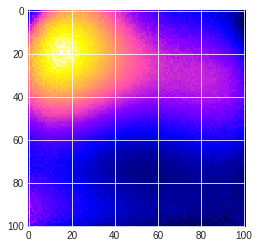

In [43]:
plt.imshow(data_pred_Kfolding)

In [44]:
mse_ols = MSE(reg.f, data_pred_Kfolding)
rmse_ols = np.sqrt(mse_ols)
r2_ols = r2_score(reg.f, data_pred_Kfolding)
print("mse, rmse and r2 score for k-folding with k=10", mse_ols,rmse_ols,r2_ols)

mse_ols_n = MSE(franke_noiseless, data_pred_Kfolding)
rmse_ols_n = np.sqrt(mse)
r2_ols_n = r2_score(franke_noiseless, data_pred_Kfolding)
print("metrics vs noiseless franke: ", mse_ols_n, rmse_ols_n, r2_ols_n)

mse, rmse and r2 score for k-folding with k=10 1.0114123365305105 1.0056899803271933 0.040743047861023535
metrics vs noiseless franke:  0.004001261899877569 0.06124926259703897 0.8671971138599176


**Solving for different values of K**

In [45]:
data_pred_list = []
for i in trange(5, 50, 2):
    K = i
    data_pred = reg.solveKFold(K=K, poly_order=5, solver="OLS")
    data_pred_list.append(data_pred)

100%|██████████| 23/23 [00:13<00:00,  1.02it/s]


In [47]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
for i in range(len(data_pred_list)):
    data_pred = data_pred_list[i]
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))

**MSE and R2-plots for different values of K**

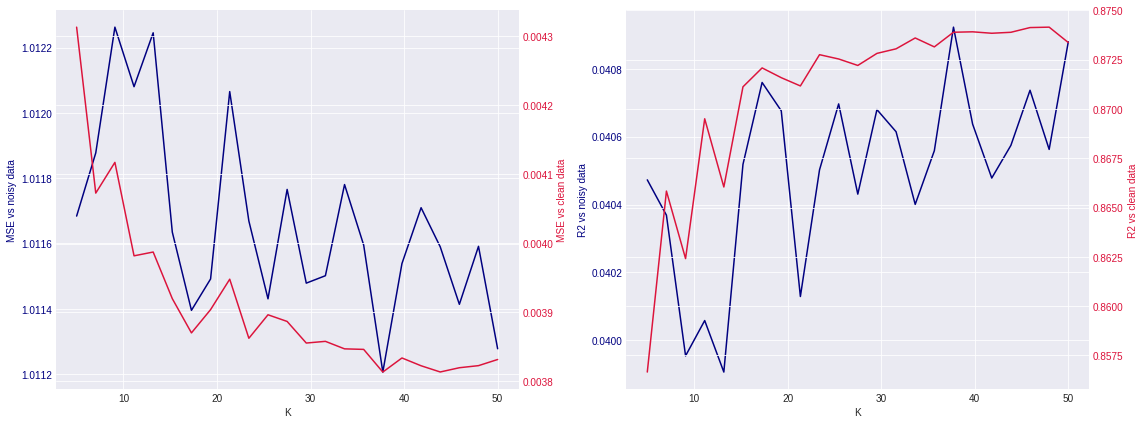

In [48]:
n = len(mse_list)
k = np.linspace(5,50,n)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.plot(k,mse_list, c = "navy", label="noisy data");
ax11.plot(k,mse_list_noiseless, c="crimson", label="noiseless data")
ax1.set_xlabel("K")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("MSE vs clean data", color="crimson");
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")

ax2.plot(k,r2_list, c="navy", label="noisy data");
ax22.plot(k,r2_list_noiseless, c="crimson", label="noiesless data")
ax2.set_xlabel("K")
ax2.set_ylabel("R2 vs noisy data", color="navy");
ax22.set_ylabel("R2 vs clean data", color="crimson");
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.tight_layout()

**K-FOLD MEAN**

In [12]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
for j in trange(0,5,1):
    data_pred_list = []
    for i in range(5, 50, 5):
        K = i
        data_pred = reg.solveKFold(K=K, poly_order=5, solver="OLS")
        data_pred_list.append(data_pred)
        
    for i in range(len(data_pred_list)):
        data_pred = data_pred_list[i]
        #mse_list.append(MSE(reg.f, data_pred))
        mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
        r2_list.append(r2_score(reg.f, data_pred))
        r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))

print("mse list length=", len(mse_list))

'\nmse_list = []\nmse_list_noiseless = []\nr2_list = []\nr2_list_noiseless = []\nfor j in trange(0,5,1):\n    data_pred_list = []\n    for i in range(5, 50, 2):\n        K = i\n        data_pred = reg.solveKFold(K=K, poly_order=5, solver="OLS")\n        data_pred_list.append(data_pred)\n    for i in range(len(data_pred_list)):\n        data_pred = data_pred_list[i]\n        mse_list.append(MSE(reg.f, data_pred))\n        mse_list_noiseless.append(MSE(franke_noiseless, data_pred))\n        r2_list.append(r2_score(reg.f, data_pred))\n        r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))\n\nprint("mse list length=", len(mse_list))\n'

In [ ]:
n = 5
mse_array = np.zeros(0,n,n+1)
mse_array_noiseless = np.zeros(0,n,n+1)
r2_array = np.zeros(0,n,n+1)
r2_array_noiseless = np.zeros(0,n,n+1)

**RIDGE**

In [13]:
data_pred_ridge = reg.solveKFold(K=10, poly_order=5, solver="Ridge")

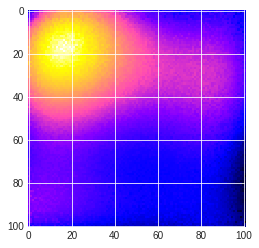

In [14]:
plt.imshow(data_pred_ridge);

In [15]:
mse_list_ridge = []
mse_list_noiseless_ridge = []
r2_list_ridge = []
r2_list_noiseless_ridge = []
lamda_list_ridge = np.logspace(3, -8, 16)
for i in trange(len(lamda_list_ridge)):
    lamda = lamda_list_ridge[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Ridge", lamda=lamda)
    mse_list_ridge.append(MSE(reg.f, data_pred))
    mse_list_noiseless_ridge.append(MSE(franke_noiseless, data_pred))
    r2_list_ridge.append(r2_score(reg.f, data_pred))
    r2_list_noiseless_ridge.append(r2_score(franke_noiseless, data_pred))

100%|██████████| 16/16 [00:03<00:00,  4.88it/s]


**Plots showing how the error behaves for increasing values of Lambda** 

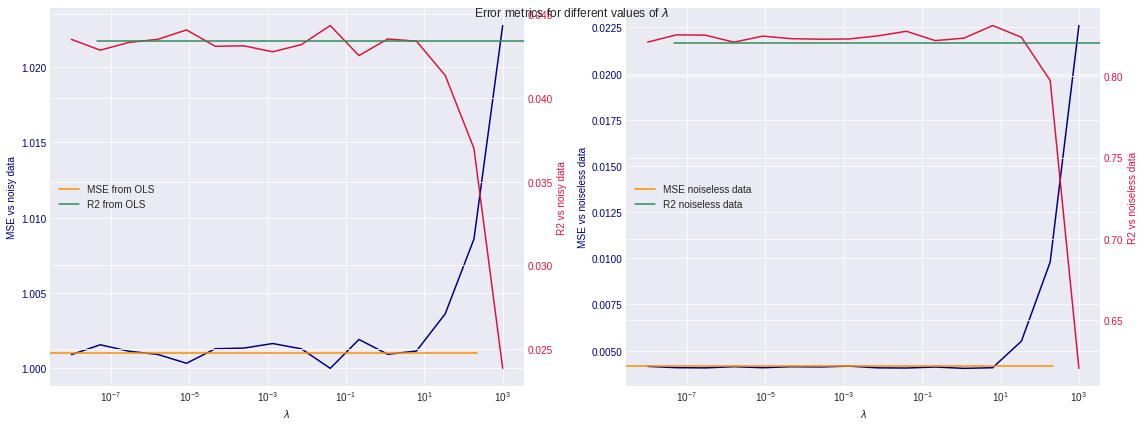

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.semilogx(lamda_list_ridge, mse_list_ridge, c="navy");
ax11.semilogx(lamda_list_ridge, r2_list_ridge, c="crimson");


ax2.semilogx(lamda_list_ridge, mse_list_noiseless_ridge, c="navy")
ax22.semilogx(lamda_list_ridge, r2_list_noiseless_ridge, c="crimson")


line1 = ax1.axhline(y=mse_ols, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")
line3 = ax2.axhline(y=mse_ols_n, xmin = 0.0, xmax = 0.9, color='darkorange', label="MSE noiseless data")
line4 = ax22.axhline(y=r2_ols_n, xmin = 0.1, xmax = 1.0, color='seagreen', label="R2 noiseless data")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)
ax2.legend((line3, line4), ("MSE noiseless data", "R2 noiseless data"), loc = 6)

ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("R2 vs noisy data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
ax2.set_xlabel(r"$\lambda$")
ax2.set_ylabel("MSE vs noiseless data", color="navy");
ax22.set_ylabel("R2 vs noiseless data", color="crimson")
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.suptitle("Error metrics for different values of $\lambda$ ")
fig.tight_layout()

In [17]:
reg.solveCoefficients(solver="Ridge")

array([ 0.33645234, -0.76856351,  0.3294267 ,  1.07640302, -0.49997075,
       -0.46388726, -0.20174887,  0.61605123, -0.92134816, -0.20322165,
        0.67178533,  0.5841824 , -0.41818721, -0.02432639,  0.14593933,
        0.12684374, -0.48795694,  0.33318717, -0.67382068,  0.40477772,
       -0.08649317])

**LASSO**

In [18]:
data_pred_lasso = reg.solveKFold(K=10,poly_order=5,solver='Lasso')

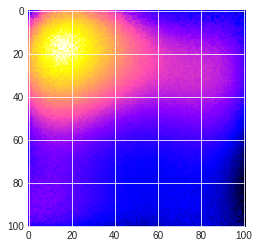

In [19]:
plt.imshow(data_pred_lasso)

In [20]:
mse = MSE(reg.f, data_pred_lasso)
rmse = np.sqrt(mse)
r2 = r2_score(reg.f, data_pred_lasso)
print("mse, rmse and r2 score for lasso,", mse, rmse, r2)

mse, rmse and r2 score for lasso, 1.0010131909050375 1.0005064671980075 0.04339914900299058


In [21]:
reg.solveCoefficients(solver="Lasso")

array([ 0.34402849, -0.74411383,  0.29760094,  0.91309968, -0.4714934 ,
       -0.31201955, -0.1940432 ,  0.59124115, -0.81698933, -0.18365595,
        0.5880316 ,  0.55235721, -0.31522115, -0.00602435,  0.09979572,
        0.03836918, -0.46839159,  0.28569944, -0.64534395,  0.32158216,
       -0.        ])

In [22]:
data_pred_lasso_comparison = reg.solveKFold(K=10, poly_order=5, solver='Lasso')

In [23]:
mse_list_lasso = []
mse_list_noiseless_lasso = []
r2_list_lasso = []
r2_list_noiseless_lasso = []
lamda_list_lasso = np.logspace(-2, -8, 16)
for i in trange(len(lamda_list_lasso)):
    lamda = lamda_list_lasso[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Lasso", lamda=lamda)
    mse_list_lasso.append(MSE(reg.f, data_pred))
    mse_list_noiseless_lasso.append(MSE(franke_noiseless, data_pred))
    r2_list_lasso.append(r2_score(reg.f, data_pred))
    r2_list_noiseless_lasso.append(r2_score(franke_noiseless, data_pred))

100%|██████████| 16/16 [01:18<00:00,  9.12s/it]


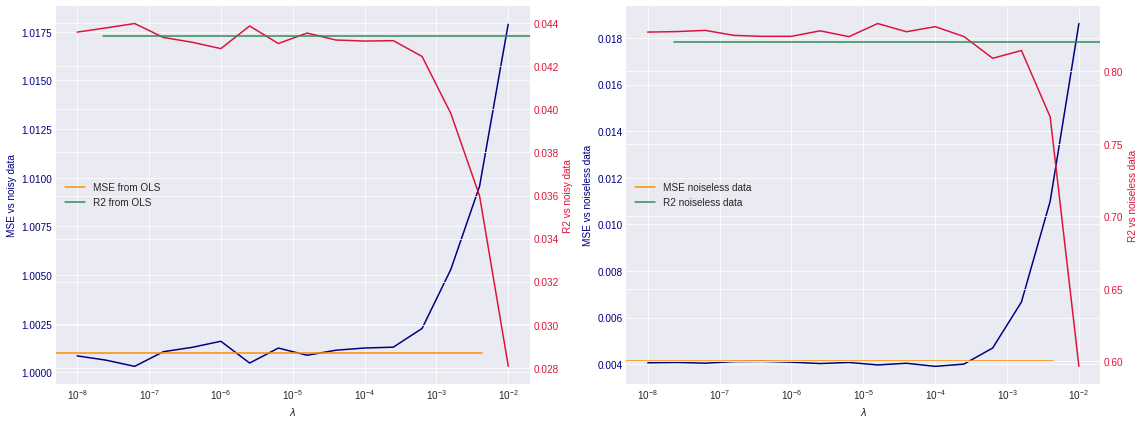

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax11 = ax1.twinx(); ax22 = ax2.twinx()
ax1.semilogx(lamda_list_lasso, mse_list_lasso, c="navy");
ax11.semilogx(lamda_list_lasso, r2_list_lasso, c="crimson");


ax2.semilogx(lamda_list_lasso, mse_list_noiseless_lasso, c="navy")
ax22.semilogx(lamda_list_lasso, r2_list_noiseless_lasso, c="crimson")


line1 = ax1.axhline(y=mse_ols, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")
line3 = ax2.axhline(y=mse_ols_n, xmin = 0.0, xmax = 0.9, color='darkorange', label="MSE noiseless data")
line4 = ax22.axhline(y=r2_ols_n, xmin = 0.1, xmax = 1.0, color='seagreen', label="R2 noiseless data")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)
ax2.legend((line3, line4), ("MSE noiseless data", "R2 noiseless data"), loc = 6)

ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax11.set_ylabel("R2 vs noisy data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
ax2.set_xlabel(r"$\lambda$")
ax2.set_ylabel("MSE vs noiseless data", color="navy");
ax22.set_ylabel("R2 vs noiseless data", color="crimson")
ax2.tick_params(axis='y', labelcolor="navy")
ax22.tick_params(axis='y', labelcolor="crimson")
fig.tight_layout()

**Errors for optimal values of lambda in both Ridge and Lasso compared with regular OLS**

In [25]:
data_pred_ridge_optimal = reg.solveKFold(K=10, poly_order=5, lamda = 1e-1, solver="Ridge")
data_pred_lasso_optimal = reg.solveKFold(K=10,poly_order=5, lamda = 1e-5, solver='Lasso')

In [26]:
MSE_ridge_optimal = MSE(reg.f, data_pred_ridge_optimal)
R2_ridge_optimal = r2_score(reg.f, data_pred_ridge_optimal)

MSE_ridge_optimal_n = MSE(franke_noiseless, data_pred_ridge_optimal)
R2_ridge_optimal_n = r2_score(franke_noiseless, data_pred_ridge_optimal)

MSE_lasso_optimal = MSE(reg.f, data_pred_lasso_optimal)
R2_lasso_optimal = r2_score(reg.f, data_pred_lasso_optimal)

MSE_lasso_optimal_n = MSE(franke_noiseless, data_pred_lasso_optimal)
R2_lasso_optimal_n = r2_score(franke_noiseless, data_pred_lasso_optimal)

#mse_ols, mse_ols_n, r2_ols, r2_ols_n

print("MSE and R2 score for optimal lambda in Ridge method compared to noisy data =", MSE_ridge_optimal, R2_ridge_optimal)
print("MSE and R2 score for optimal lambda in Ridge method compared to noiseless data=", MSE_ridge_optimal_n, R2_ridge_optimal_n)

print("\n")

print("MSE and R2 score for optimal lambda in Lasso method compared to noisy data =", MSE_lasso_optimal, R2_lasso_optimal)
print("MSE and R2 score for optimal lambda in Lasso method compared to noiseless data=", MSE_lasso_optimal_n, R2_lasso_optimal_n)

print("\n")

print("MSE and R2 score for optimal lambda in OLS method compared to noisy data =", mse_ols, r2_ols)
print("MSE and R2 score for optimal lambda in OLS method compared to noiseless data=", mse_ols_n, r2_ols_n)

MSE and R2 score for optimal lambda in Ridge method compared to noisy data = 1.0004794729769058 0.04385568773419073
MSE and R2 score for optimal lambda in Ridge method compared to noiseless data= 0.004077844257217805 0.827005072018189


MSE and R2 score for optimal lambda in Lasso method compared to noisy data = 1.0018033830022257 0.042645334183332606
MSE and R2 score for optimal lambda in Lasso method compared to noiseless data= 0.004133412184255394 0.82070438284948


MSE and R2 score for optimal lambda in OLS method compared to noisy data = 1.001007909744197 0.04341263708400598
MSE and R2 score for optimal lambda in OLS method compared to noiseless data= 0.004149800914642737 0.820304458544211


# REAL DATA

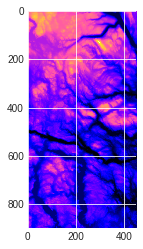

In [27]:
terrain1 = imread("../input_data/SRTM_data_Norway_1.tif")[::4, ::4]
plt.imshow(terrain1);

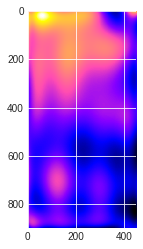

In [28]:
reg.load_matrix_data(terrain1)
beta_ols = reg.solveCoefficients(poly_order=10, solver="OLS")
data_pred_ols = reg.apply_model(beta_ols, reg.x_mesh, reg.y_mesh)

plt.imshow(data_pred_ols);

In [29]:
mse_ols_real = MSE(terrain1,data_pred_ols)
r2_ols_real = r2_score(terrain1,data_pred_ols)

print("MSE and R2 score for real data with OLS method and no sampling=", mse_ols_real, r2_ols_real)

MSE and R2 score for real data with OLS method and no sampling= 33423.088138169966 0.5762436888588063


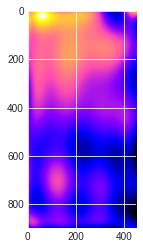

In [30]:
data_pred_Kfold = reg.solveKFold(K=10, poly_order=10, solver="OLS")
plt.imshow(data_pred_Kfold)

In [31]:
mse_ols_kfold_real = MSE(terrain1,data_pred_Kfold)
r2_ols_kfold_real = r2_score(terrain1,data_pred_Kfold)

print("MSE and R2 score for real data with OLS method and K-folding=", mse_ols_kfold_real, r2_ols_kfold_real)

MSE and R2 score for real data with OLS method and K-folding= 33435.92920349183 0.5760657508061787


In [32]:
mse_list_ridge = []
mse_list_noiseless_ridge = []
r2_list_ridge = []
r2_list_noiseless_ridge = []
lamda_list_ridge = np.logspace(3, -8, 16)
for i in trange(len(lamda_list_ridge)):
    lamda = lamda_list_ridge[i]
    data_pred = reg.solveKFold(K=10, poly_order=10, solver="Ridge", lamda=lamda)
    mse_list_ridge.append(MSE(terrain1, data_pred))
    r2_list_ridge.append(r2_score(terrain1, data_pred))

100%|██████████| 16/16 [04:12<00:00, 15.77s/it]


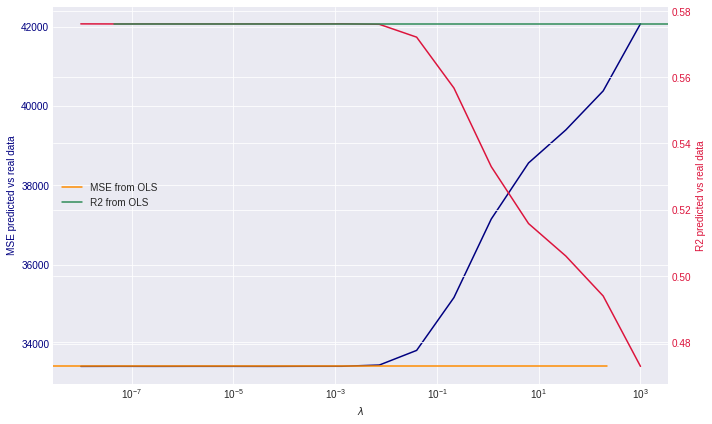

In [33]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax11 = ax1.twinx(); 
ax1.semilogx(lamda_list_ridge, mse_list_ridge, c="navy");
ax11.semilogx(lamda_list_ridge, r2_list_ridge, c="crimson");

line1 = ax1.axhline(y=mse_ols_kfold_real, xmin=0.0, xmax=0.9, color='darkorange',label="MSE from OLS")
line2 = ax11.axhline(y=r2_ols_kfold_real, xmin=0.1, xmax=1.0, color='seagreen', label="R2 from OLS")

ax1.legend((line1,line2), ("MSE from OLS", "R2 from OLS"), loc = 6)

ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("MSE predicted vs real data", color="navy");
ax11.set_ylabel("R2 predicted vs real data", color="crimson")
ax1.tick_params(axis='y', labelcolor="navy")
ax11.tick_params(axis='y', labelcolor="crimson")
fig.tight_layout()